# kap.org.tr sitesinden borsa istanbul şirketlerinin listesi alınarak , yfinance paketi ile veriler elde edildi , sonrasında tahmin işlemi yapıldı

In [2]:
#!pip install tabulate
#!pip install yfinance
#!pip install prophet

In [3]:
import pandas as pd
from bs4 import BeautifulSoup #canlı web sitesinin kaynak kodunu okuma , parçalama , veri çekme
import requests
import yfinance as yf #finance paketi
import pickle

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from prophet import Prophet
from prophet.plot import plot_plotly,plot_components_plotly
import yfinance as yf

In [4]:
# Aşağıdaki hücrede yer alan datayı 1 kez excel aldık sonrasında excel üzerinden devam ediyorum.
page = requests.get('https://www.kap.org.tr/tr/bist-sirketler')
soup = BeautifulSoup(page.content, 'html.parser')
hisseler = soup.find_all('div', {'class': 'w-clearfix w-inline-block comp-row'}) #sitedeki istediğimiz dataya odaklandık

hisse_kodu = []
hisse_firmasi = []
hisse_firma_link = []
hisse_ili = []
bagimsiz_denetim_kur = []

for hisse in hisseler:
    hisse_kodu.append(hisse.find('div', {'class': 'comp-cell _04 vtable'}).a.text.strip())
    hisse_firmasi.append(hisse.find('div', {'class': 'comp-cell _14 vtable'}).a.text.strip())
    hisse_firma_link.append('https://www.kap.org.tr' + hisse.find('div', {'class': 'comp-cell _14 vtable'}).a.get('href'))
    hisse_ili.append(hisse.find('div', {'class': 'comp-cell _12 vtable'}).div.text.strip())
    bagimsiz_denetim_kur.append(hisse.find('div', {'class': 'comp-cell _11 vtable'}).a.text.strip())

#Dizimizin içine web sitesinden aldığımız dataları ekledik.

#Verileri bir DataFrame'e dönüştürdük
data = {
    'Hisse Kodu': hisse_kodu,
    'Hisse Firması': hisse_firmasi,
    'Hisse Firma Link': hisse_firma_link,
    'Hisse İli': hisse_ili,
    'Bağımsız Denetim Kurumu': bagimsiz_denetim_kur
}
df = pd.DataFrame(data)

#df.isnull().sum()
#df.describe()
#df.info
df.to_excel('borsa_istanbul.xlsx', index=False) # excel olarak export alındı sürekli canlı veri çekmemek için

In [9]:
df=pd.read_excel('borsa_istanbul.xlsx')
df.head()

,Hisse Kodu,Hisse Firması,Hisse Firma Link,Hisse İli,Bağımsız Denetim Kurumu
0,BINHO,1000 YATIRIMLAR HOLDİNG A.Ş.,https://www.kap.org.tr/tr/sirket-bilgileri/oze...,İSTANBUL,EREN BAĞIMSIZ DENETİM A.Ş.
1,AVOD,A.V.O.D. KURUTULMUŞ GIDA VE TARIM ÜRÜNLERİ SAN...,https://www.kap.org.tr/tr/sirket-bilgileri/oze...,İZMİR,HSY DANIŞMANLIK VE BAĞIMSIZ DENETİM A.Ş.
2,"A1CAP, ACP",A1 CAPITAL YATIRIM MENKUL DEĞERLER A.Ş.,https://www.kap.org.tr/tr/sirket-bilgileri/oze...,İSTANBUL,PKF ADAY BAĞIMSIZ DENETİM A.Ş.
3,ACSEL,ACISELSAN ACIPAYAM SELÜLOZ SANAYİ VE TİCARET A.Ş.,https://www.kap.org.tr/tr/sirket-bilgileri/oze...,DENİZLİ,PwC BAĞIMSIZ DENETİM VE SERBEST MUHASEBECİ MAL...
4,ADEL,ADEL KALEMCİLİK TİCARET VE SANAYİ A.Ş.,https://www.kap.org.tr/tr/sirket-bilgileri/oze...,KOCAELİ,PwC BAĞIMSIZ DENETİM VE SERBEST MUHASEBECİ MAL...


In [10]:
#hisse bilgilerine ait detaylı fiyat bilgileri dışarı export almadan önce hazırlık çalışması

# İlgili sütunu aldık virgül sonrasını kesip attık , gelen data da tek sutunda virgüllü kayıtlar vardı
hisse_listesi = df['Hisse Kodu']
hisse_listesi = [hisse.split(',')[0].strip() for hisse in hisse_listesi]

s = 0
hisse_bilgi = []

for h1 in hisse_listesi:
    print(h1) #işlem yapılan hisse senetini görmek için yazdırıyorum
    try:
        data = yf.download(h1 + '.IS', start="2013-01-01", end=None) #2013'ten günümüze kadar olan değişim
        data['Hisse Kodu'] = h1
        hisse_bilgi.append(data)
    except Exception as e:
        print(f'Hata oluştu: {e}. {h1} sembolü atlandı.')
    s = s + 1

hisse_bilgi_birlesik = pd.concat(hisse_bilgi, keys=hisse_listesi, names=['Hisse Kodu'])

# "Date" sütununu tarih olarak tanımla ve yeni sütunlar oluştur
hisse_bilgi_birlesik['Date'] = pd.to_datetime(hisse_bilgi_birlesik.index.get_level_values('Date'), format='%Y-%m-%d')
hisse_bilgi_birlesik['year'] = hisse_bilgi_birlesik['Date'].dt.year
hisse_bilgi_birlesik['month'] = hisse_bilgi_birlesik['Date'].dt.month
hisse_bilgi_birlesik['day'] = hisse_bilgi_birlesik['Date'].dt.day

# Başlık satırlarını sildik
hisse_detaylari = hisse_bilgi_birlesik.reset_index(drop=True)

with open('hisse_detay_bilgileri.pkl', 'wb') as picklefile:
    pickle.dump(hisse_detaylari, picklefile)
    
#hisse_detaylari.head()

BINHO
[*********************100%%**********************]  1 of 1 completed
AVOD
[*********************100%%**********************]  1 of 1 completed
A1CAP
[*********************100%%**********************]  1 of 1 completed
ACSEL
[*********************100%%**********************]  1 of 1 completed
ADEL
[*********************100%%**********************]  1 of 1 completed
ADESE
[*********************100%%**********************]  1 of 1 completed
ADGYO
[*********************100%%**********************]  1 of 1 completed
AFYON
[*********************100%%**********************]  1 of 1 completed
AGHOL
[*********************100%%**********************]  1 of 1 completed
AGESA
[*********************100%%**********************]  1 of 1 completed
AGROT
[*********************100%%**********************]  1 of 1 completed
AHGAZ
[*********************100%%**********************]  1 of 1 completed
AKSFA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['AKSFA.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



AKFK
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['AKFK.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



AKM
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['AKM.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



AKBNK
[*********************100%%**********************]  1 of 1 completed
AKCKM
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['AKCKM.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



AKCNS
[*********************100%%**********************]  1 of 1 completed
AKDFA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['AKDFA.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



AKYHO
[*********************100%%**********************]  1 of 1 completed
AKENR
[*********************100%%**********************]  1 of 1 completed
AKFGY
[*********************100%%**********************]  1 of 1 completed
AKFYE
[*********************100%%**********************]  1 of 1 completed
ATEKS
[*********************100%%**********************]  1 of 1 completed
AKSGY
[*********************100%%**********************]  1 of 1 completed
AKMGY
[*********************100%%**********************]  1 of 1 completed
AKSA
[*********************100%%**********************]  1 of 1 completed
AKSEN
[*********************100%%**********************]  1 of 1 completed
AKGRT
[*********************100%%**********************]  1 of 1 completed
AKSUE
[*********************100%%**********************]  1 of 1 completed
AKTVK
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['AKTVK.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



AFB
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['AFB.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



ALCAR
[*********************100%%**********************]  1 of 1 completed
ALGYO
[*********************100%%**********************]  1 of 1 completed
ALARK
[*********************100%%**********************]  1 of 1 completed
ALBRK
[*********************100%%**********************]  1 of 1 completed
ALCTL
[*********************100%%**********************]  1 of 1 completed
ALFAS
[*********************100%%**********************]  1 of 1 completed
ALJF
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['ALJF.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



ALKIM
[*********************100%%**********************]  1 of 1 completed
ALKA
[*********************100%%**********************]  1 of 1 completed
ALNUS
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['ALNUS.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



ALFIN
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['ALFIN.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



AYCES
[*********************100%%**********************]  1 of 1 completed
ALMAD
[*********************100%%**********************]  1 of 1 completed
ANSGR
[*********************100%%**********************]  1 of 1 completed
AEFES
[*********************100%%**********************]  1 of 1 completed
ANHYT
[*********************100%%**********************]  1 of 1 completed
ASUZU
[*********************100%%**********************]  1 of 1 completed
ANGEN
[*********************100%%**********************]  1 of 1 completed
ANELE
[*********************100%%**********************]  1 of 1 completed
ARCLK
[*********************100%%**********************]  1 of 1 completed
ARDYZ
[*********************100%%**********************]  1 of 1 completed
ARENA
[*********************100%%**********************]  1 of 1 completed
ARNFK
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['ARNFK.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



ARSAN
[*********************100%%**********************]  1 of 1 completed
ARZUM
[*********************100%%**********************]  1 of 1 completed
ASGYO
[*********************100%%**********************]  1 of 1 completed
ASELS
[*********************100%%**********************]  1 of 1 completed
ASTOR
[*********************100%%**********************]  1 of 1 completed
ATAGY
[*********************100%%**********************]  1 of 1 completed
ATA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['ATA.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



ATAKP
[*********************100%%**********************]  1 of 1 completed
AGYO
[*********************100%%**********************]  1 of 1 completed
ATLFA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['ATLFA.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



ATSYH
[*********************100%%**********************]  1 of 1 completed
ATLAS
[*********************100%%**********************]  1 of 1 completed
ATATP
[*********************100%%**********************]  1 of 1 completed
AVGYO
[*********************100%%**********************]  1 of 1 completed
AVTUR
[*********************100%%**********************]  1 of 1 completed
AVHOL
[*********************100%%**********************]  1 of 1 completed
AYDEM
[*********************100%%**********************]  1 of 1 completed
AYEN
[*********************100%%**********************]  1 of 1 completed
AYES
[*********************100%%**********************]  1 of 1 completed
AYGAZ
[*********************100%%**********************]  1 of 1 completed
AZTEK
[*********************100%%**********************]  1 of 1 completed
BAGFS
[*********************100%%**********************]  1 of 1 completed
BAKAB
[*********************100%%**********************]  1 of 1 completed
BALAT
[*******************


1 Failed download:
['BRKT.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



BRKSN
[*********************100%%**********************]  1 of 1 completed
BJKAS
[*********************100%%**********************]  1 of 1 completed
BEYAZ
[*********************100%%**********************]  1 of 1 completed
BIENF
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['BIENF.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



BIENY
[*********************100%%**********************]  1 of 1 completed
BLCYT
[*********************100%%**********************]  1 of 1 completed
BLKOM
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['BLKOM.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



BIMAS
[*********************100%%**********************]  1 of 1 completed
BIOEN
[*********************100%%**********************]  1 of 1 completed
BRKVY
[*********************100%%**********************]  1 of 1 completed
BRKO
[*********************100%%**********************]  1 of 1 completed
BRLSM
[*********************100%%**********************]  1 of 1 completed
BRMEN
[*********************100%%**********************]  1 of 1 completed
BIZIM
[*********************100%%**********************]  1 of 1 completed
BMSTL
[*********************100%%**********************]  1 of 1 completed
BMSCH
[*********************100%%**********************]  1 of 1 completed
BNPPI
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['BNPPI.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



BNPFK
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['BNPFK.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



BOBET
[*********************100%%**********************]  1 of 1 completed
BORLS
[*********************100%%**********************]  1 of 1 completed
BRSAN
[*********************100%%**********************]  1 of 1 completed
BRYAT
[*********************100%%**********************]  1 of 1 completed
BFREN
[*********************100%%**********************]  1 of 1 completed
BOSSA
[*********************100%%**********************]  1 of 1 completed
BRISA
[*********************100%%**********************]  1 of 1 completed
BURCE
[*********************100%%**********************]  1 of 1 completed
BURVA
[*********************100%%**********************]  1 of 1 completed
BUCIM
[*********************100%%**********************]  1 of 1 completed
BVSAN
[*********************100%%**********************]  1 of 1 completed
BIGCH
[*********************100%%**********************]  1 of 1 completed
CRFSA
[*********************100%%**********************]  1 of 1 completed
CASA
[******************


1 Failed download:
['CREAN.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



CCOLA
[*********************100%%**********************]  1 of 1 completed
CONSE
[*********************100%%**********************]  1 of 1 completed
COSMO
[*********************100%%**********************]  1 of 1 completed
CRDFA
[*********************100%%**********************]  1 of 1 completed
CVKMD
[*********************100%%**********************]  1 of 1 completed
CWENE
[*********************100%%**********************]  1 of 1 completed
CAGFA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['CAGFA.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



CLDNM
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['CLDNM.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



CANTE
[*********************100%%**********************]  1 of 1 completed
CATES
[*********************100%%**********************]  1 of 1 completed
CLEBI
[*********************100%%**********************]  1 of 1 completed
CELHA
[*********************100%%**********************]  1 of 1 completed
CLKMT
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['CLKMT.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



CEMAS
[*********************100%%**********************]  1 of 1 completed
CEMTS
[*********************100%%**********************]  1 of 1 completed
CMBTN
[*********************100%%**********************]  1 of 1 completed
CMENT
[*********************100%%**********************]  1 of 1 completed
CIMSA
[*********************100%%**********************]  1 of 1 completed
CUSAN
[*********************100%%**********************]  1 of 1 completed
DYBNK
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['DYBNK.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



DAGI
[*********************100%%**********************]  1 of 1 completed
DAGHL
[*********************100%%**********************]  1 of 1 completed
DAPGM
[*********************100%%**********************]  1 of 1 completed
DARDL
[*********************100%%**********************]  1 of 1 completed
DGATE
[*********************100%%**********************]  1 of 1 completed
DGRVK
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['DGRVK.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



DMSAS
[*********************100%%**********************]  1 of 1 completed
DENGE
[*********************100%%**********************]  1 of 1 completed
DENFA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['DENFA.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



DNFIN
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['DNFIN.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



DZGYO
[*********************100%%**********************]  1 of 1 completed
DZY
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['DZY.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



DERIM
[*********************100%%**********************]  1 of 1 completed
DERHL
[*********************100%%**********************]  1 of 1 completed
DESA
[*********************100%%**********************]  1 of 1 completed
DESPC
[*********************100%%**********************]  1 of 1 completed
DTYGD
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['DTYGD.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



DEVA
[*********************100%%**********************]  1 of 1 completed
DNISI
[*********************100%%**********************]  1 of 1 completed
DIRIT
[*********************100%%**********************]  1 of 1 completed
DITAS
[*********************100%%**********************]  1 of 1 completed
DMRGD
[*********************100%%**********************]  1 of 1 completed
DOCO
[*********************100%%**********************]  1 of 1 completed
DOFER
[*********************100%%**********************]  1 of 1 completed
DOBUR
[*********************100%%**********************]  1 of 1 completed
DOHOL
[*********************100%%**********************]  1 of 1 completed
DTRND
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['DTRND.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



DGNMO
[*********************100%%**********************]  1 of 1 completed
ARASE
[*********************100%%**********************]  1 of 1 completed
DOGUB
[*********************100%%**********************]  1 of 1 completed
DGGYO
[*********************100%%**********************]  1 of 1 completed
DOAS
[*********************100%%**********************]  1 of 1 completed
DFKTR
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['DFKTR.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



DOKTA
[*********************100%%**********************]  1 of 1 completed
DURDO
[*********************100%%**********************]  1 of 1 completed
DNYVA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['DNYVA.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



DYOBY
[*********************100%%**********************]  1 of 1 completed
EDATA
[*********************100%%**********************]  1 of 1 completed
EBEBK
[*********************100%%**********************]  1 of 1 completed
ECZYT
[*********************100%%**********************]  1 of 1 completed
EDIP
[*********************100%%**********************]  1 of 1 completed
EGEEN
[*********************100%%**********************]  1 of 1 completed
EGGUB
[*********************100%%**********************]  1 of 1 completed
EGPRO
[*********************100%%**********************]  1 of 1 completed
EGSER
[*********************100%%**********************]  1 of 1 completed
EPLAS
[*********************100%%**********************]  1 of 1 completed
ECILC
[*********************100%%**********************]  1 of 1 completed
EKIZ
[*********************100%%**********************]  1 of 1 completed
EKOFA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['EKOFA.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



EKOS
[*********************100%%**********************]  1 of 1 completed
EKSUN
[*********************100%%**********************]  1 of 1 completed
ELITE
[*********************100%%**********************]  1 of 1 completed
EMKEL
[*********************100%%**********************]  1 of 1 completed
EMNIS
[*********************100%%**********************]  1 of 1 completed
EMIRV
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['EMIRV.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



EKTVK
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['EKTVK.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



EKGYO
[*********************100%%**********************]  1 of 1 completed
EMVAR
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['EMVAR.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



ENJSA
[*********************100%%**********************]  1 of 1 completed
ENERY
[*********************100%%**********************]  1 of 1 completed
ENKAI
[*********************100%%**********************]  1 of 1 completed
ENSRI
[*********************100%%**********************]  1 of 1 completed
ERBOS
[*********************100%%**********************]  1 of 1 completed
ERCB
[*********************100%%**********************]  1 of 1 completed
EREGL
[*********************100%%**********************]  1 of 1 completed
ERGLI
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['ERGLI.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



KIMMR
[*********************100%%**********************]  1 of 1 completed
ERSU
[*********************100%%**********************]  1 of 1 completed
ESCAR
[*********************100%%**********************]  1 of 1 completed
ESCOM
[*********************100%%**********************]  1 of 1 completed
ESEN
[*********************100%%**********************]  1 of 1 completed
ETILR
[*********************100%%**********************]  1 of 1 completed
EUKYO
[*********************100%%**********************]  1 of 1 completed
EUYO
[*********************100%%**********************]  1 of 1 completed
ETYAT
[*********************100%%**********************]  1 of 1 completed
EUHOL
[*********************100%%**********************]  1 of 1 completed
TEZOL
[*********************100%%**********************]  1 of 1 completed
EUREN
[*********************100%%**********************]  1 of 1 completed
EUPWR
[*********************100%%**********************]  1 of 1 completed
EYGYO
[********************


1 Failed download:
['FSDAT.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



FMIZP
[*********************100%%**********************]  1 of 1 completed
FENER
[*********************100%%**********************]  1 of 1 completed
FIBAF
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['FIBAF.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



FBB
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['FBB.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



FLAP
[*********************100%%**********************]  1 of 1 completed
FONET
[*********************100%%**********************]  1 of 1 completed
FROTO
[*********************100%%**********************]  1 of 1 completed
FORMT
[*********************100%%**********************]  1 of 1 completed
FORTE
[*********************100%%**********************]  1 of 1 completed
FRIGO
[*********************100%%**********************]  1 of 1 completed
FZLGY
[*********************100%%**********************]  1 of 1 completed
GWIND
[*********************100%%**********************]  1 of 1 completed
GSRAY
[*********************100%%**********************]  1 of 1 completed
GAPIN
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['GAPIN.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



GARFA
[*********************100%%**********************]  1 of 1 completed
GARFL
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['GARFL.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



GRFIN
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['GRFIN.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



GRNYO
[*********************100%%**********************]  1 of 1 completed
GEDIK
[*********************100%%**********************]  1 of 1 completed
GEDZA
[*********************100%%**********************]  1 of 1 completed
GLCVY
[*********************100%%**********************]  1 of 1 completed
GENIL
[*********************100%%**********************]  1 of 1 completed
GENTS
[*********************100%%**********************]  1 of 1 completed
GEREL
[*********************100%%**********************]  1 of 1 completed
GZNMI
[*********************100%%**********************]  1 of 1 completed
GIPTA
[*********************100%%**********************]  1 of 1 completed
GMTAS
[*********************100%%**********************]  1 of 1 completed
GESAN
[*********************100%%**********************]  1 of 1 completed
GLB
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['GLB.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



GLYHO
[*********************100%%**********************]  1 of 1 completed
GGBVK
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['GGBVK.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



GSIPD
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['GSIPD.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



GOODY
[*********************100%%**********************]  1 of 1 completed
GOKNR
[*********************100%%**********************]  1 of 1 completed
GOLTS
[*********************100%%**********************]  1 of 1 completed
GOZDE
[*********************100%%**********************]  1 of 1 completed
GRTRK
[*********************100%%**********************]  1 of 1 completed
GSDDE
[*********************100%%**********************]  1 of 1 completed
GSDHO
[*********************100%%**********************]  1 of 1 completed
GUBRF
[*********************100%%**********************]  1 of 1 completed
GLRYH
[*********************100%%**********************]  1 of 1 completed
GRSEL
[*********************100%%**********************]  1 of 1 completed
SAHOL
[*********************100%%**********************]  1 of 1 completed
HALKF
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['HALKF.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



HLGYO
[*********************100%%**********************]  1 of 1 completed
HLVKS
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['HLVKS.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



HALKI
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['HALKI.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



HATSN
[*********************100%%**********************]  1 of 1 completed
HATEK
[*********************100%%**********************]  1 of 1 completed
HDFFL
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['HDFFL.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



HDFGS
[*********************100%%**********************]  1 of 1 completed
HEDEF
[*********************100%%**********************]  1 of 1 completed
HEKTS
[*********************100%%**********************]  1 of 1 completed
HKTM
[*********************100%%**********************]  1 of 1 completed
HTTBT
[*********************100%%**********************]  1 of 1 completed
HUBVC
[*********************100%%**********************]  1 of 1 completed
HUNER
[*********************100%%**********************]  1 of 1 completed
HUZFA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['HUZFA.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



HURGZ
[*********************100%%**********************]  1 of 1 completed
ICB
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['ICB.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



ICUGS
[*********************100%%**********************]  1 of 1 completed
INGRM
[*********************100%%**********************]  1 of 1 completed
INVEO
[*********************100%%**********************]  1 of 1 completed
IAZ
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['IAZ.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



INVES
[*********************100%%**********************]  1 of 1 completed
ISKPL
[*********************100%%**********************]  1 of 1 completed
IEYHO
[*********************100%%**********************]  1 of 1 completed
IDEAS
[*********************100%%**********************]  1 of 1 completed
IDGYO
[*********************100%%**********************]  1 of 1 completed
IHEVA
[*********************100%%**********************]  1 of 1 completed
IHLGM
[*********************100%%**********************]  1 of 1 completed
IHGZT
[*********************100%%**********************]  1 of 1 completed
IHAAS
[*********************100%%**********************]  1 of 1 completed
IHLAS
[*********************100%%**********************]  1 of 1 completed
IHYAY
[*********************100%%**********************]  1 of 1 completed
IMASM
[*********************100%%**********************]  1 of 1 completed
INALR
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['INALR.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



INDES
[*********************100%%**********************]  1 of 1 completed
INFO
[*********************100%%**********************]  1 of 1 completed
INTEM
[*********************100%%**********************]  1 of 1 completed
IPEKE
[*********************100%%**********************]  1 of 1 completed
ISDMR
[*********************100%%**********************]  1 of 1 completed
ISFAK
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['ISFAK.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



ISFIN
[*********************100%%**********************]  1 of 1 completed
ISGYO
[*********************100%%**********************]  1 of 1 completed
ISGSY
[*********************100%%**********************]  1 of 1 completed
ISMEN
[*********************100%%**********************]  1 of 1 completed
ISYAT
[*********************100%%**********************]  1 of 1 completed
ISBIR
[*********************100%%**********************]  1 of 1 completed
ISSEN
[*********************100%%**********************]  1 of 1 completed
IZINV
[*********************100%%**********************]  1 of 1 completed
IZENR
[*********************100%%**********************]  1 of 1 completed
IZMDC
[*********************100%%**********************]  1 of 1 completed
IZFAS
[*********************100%%**********************]  1 of 1 completed
JANTS
[*********************100%%**********************]  1 of 1 completed
KFEIN
[*********************100%%**********************]  1 of 1 completed
KLKIM
[*****************


1 Failed download:
['KLVKS.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



KAPTESTAS001
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['KAPTESTAS001.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



KAPLM
[*********************100%%**********************]  1 of 1 completed
KRDMA
[*********************100%%**********************]  1 of 1 completed
KAREL
[*********************100%%**********************]  1 of 1 completed
KARSN
[*********************100%%**********************]  1 of 1 completed
KRTEK
[*********************100%%**********************]  1 of 1 completed
KARYE
[*********************100%%**********************]  1 of 1 completed
KARTN
[*********************100%%**********************]  1 of 1 completed
KATVK
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['KATVK.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



KTLEV
[*********************100%%**********************]  1 of 1 completed
KATMR
[*********************100%%**********************]  1 of 1 completed
KAYSE
[*********************100%%**********************]  1 of 1 completed
KNTFA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['KNTFA.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



KENT
[*********************100%%**********************]  1 of 1 completed
KERVT
[*********************100%%**********************]  1 of 1 completed
KRVGD
[*********************100%%**********************]  1 of 1 completed
KERVN
[*********************100%%**********************]  1 of 1 completed
KZBGY
[*********************100%%**********************]  1 of 1 completed
KLGYO
[*********************100%%**********************]  1 of 1 completed
KLRHO
[*********************100%%**********************]  1 of 1 completed
KMPUR
[*********************100%%**********************]  1 of 1 completed
KLMSN
[*********************100%%**********************]  1 of 1 completed
KCAER
[*********************100%%**********************]  1 of 1 completed
KFKTF
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['KFKTF.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



KOCFN
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['KOCFN.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



KCHOL
[*********************100%%**********************]  1 of 1 completed
KCSIS
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['KCSIS.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



KLSYN
[*********************100%%**********************]  1 of 1 completed
KNFRT
[*********************100%%**********************]  1 of 1 completed
KONTR
[*********************100%%**********************]  1 of 1 completed
KONYA
[*********************100%%**********************]  1 of 1 completed
KONKA
[*********************100%%**********************]  1 of 1 completed
KGYO
[*********************100%%**********************]  1 of 1 completed
KORDS
[*********************100%%**********************]  1 of 1 completed
KRPLS
[*********************100%%**********************]  1 of 1 completed
KORTS
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['KORTS.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



KOZAL
[*********************100%%**********************]  1 of 1 completed
KOZAA
[*********************100%%**********************]  1 of 1 completed
KOPOL
[*********************100%%**********************]  1 of 1 completed
KRGYO
[*********************100%%**********************]  1 of 1 completed
KRSTL
[*********************100%%**********************]  1 of 1 completed
KRONT
[*********************100%%**********************]  1 of 1 completed
KTKVK
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['KTKVK.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



KSTUR
[*********************100%%**********************]  1 of 1 completed
KUVVA
[*********************100%%**********************]  1 of 1 completed
KUYAS
[*********************100%%**********************]  1 of 1 completed
KBORU
[*********************100%%**********************]  1 of 1 completed
KZGYO
[*********************100%%**********************]  1 of 1 completed
KUTPO
[*********************100%%**********************]  1 of 1 completed
KTSKR
[*********************100%%**********************]  1 of 1 completed
LIDER
[*********************100%%**********************]  1 of 1 completed
LIDFA
[*********************100%%**********************]  1 of 1 completed
LINK
[*********************100%%**********************]  1 of 1 completed
LOGO
[*********************100%%**********************]  1 of 1 completed
LKMNH
[*********************100%%**********************]  1 of 1 completed
LRSHO
[*********************100%%**********************]  1 of 1 completed
LUKSK
[*******************


1 Failed download:
['MRBAS.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



MAGEN
[*********************100%%**********************]  1 of 1 completed
MRMAG
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['MRMAG.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



MARKA
[*********************100%%**********************]  1 of 1 completed
MAALT
[*********************100%%**********************]  1 of 1 completed
MRSHL
[*********************100%%**********************]  1 of 1 completed
MRGYO
[*********************100%%**********************]  1 of 1 completed
MARTI
[*********************100%%**********************]  1 of 1 completed
MTRKS
[*********************100%%**********************]  1 of 1 completed
MAVI
[*********************100%%**********************]  1 of 1 completed
MZHLD
[*********************100%%**********************]  1 of 1 completed
MEDTR
[*********************100%%**********************]  1 of 1 completed
MEGMT
[*********************100%%**********************]  1 of 1 completed
MEGAP
[*********************100%%**********************]  1 of 1 completed
MEKAG
[*********************100%%**********************]  1 of 1 completed
MEKMD
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['MEKMD.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



MNDRS
[*********************100%%**********************]  1 of 1 completed
MEPET
[*********************100%%**********************]  1 of 1 completed
MERCN
[*********************100%%**********************]  1 of 1 completed
MRBKF
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['MRBKF.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



MBFTR
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['MBFTR.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



MERIT
[*********************100%%**********************]  1 of 1 completed
MERKO
[*********************100%%**********************]  1 of 1 completed
MTOTO
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['MTOTO.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



METUR
[*********************100%%**********************]  1 of 1 completed
METRO
[*********************100%%**********************]  1 of 1 completed
MTRYO
[*********************100%%**********************]  1 of 1 completed
MHRGY
[*********************100%%**********************]  1 of 1 completed
MIATK
[*********************100%%**********************]  1 of 1 completed
MGROS
[*********************100%%**********************]  1 of 1 completed
MIPAZ
[*********************100%%**********************]  1 of 1 completed
MSGYO
[*********************100%%**********************]  1 of 1 completed
MPARK
[*********************100%%**********************]  1 of 1 completed
MMCAS
[*********************100%%**********************]  1 of 1 completed
MOBTL
[*********************100%%**********************]  1 of 1 completed
MNDTR
[*********************100%%**********************]  1 of 1 completed
EGEPO
[*********************100%%**********************]  1 of 1 completed
NATEN
[*****************


1 Failed download:
['NRHOL.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



NRLIN
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['NRLIN.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



NURVK
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['NURVK.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



NRBNK
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['NRBNK.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



OBASE
[*********************100%%**********************]  1 of 1 completed
ODAS
[*********************100%%**********************]  1 of 1 completed
OFSYM
[*********************100%%**********************]  1 of 1 completed
ONCSM
[*********************100%%**********************]  1 of 1 completed
OPET
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['OPET.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



ORCAY
[*********************100%%**********************]  1 of 1 completed
ORFIN
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['ORFIN.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



ORGE
[*********************100%%**********************]  1 of 1 completed
ORMA
[*********************100%%**********************]  1 of 1 completed
OMD
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['OMD.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



OSTIM
[*********************100%%**********************]  1 of 1 completed
OTKAR
[*********************100%%**********************]  1 of 1 completed
OTOKC
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['OTOKC.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



OTOSR
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['OTOSR.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



OTTO
[*********************100%%**********************]  1 of 1 completed
OYAKC
[*********************100%%**********************]  1 of 1 completed
OYA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['OYA.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



OYAYO
[*********************100%%**********************]  1 of 1 completed
OYLUM
[*********************100%%**********************]  1 of 1 completed
OZKGY
[*********************100%%**********************]  1 of 1 completed
OZGYO
[*********************100%%**********************]  1 of 1 completed
OZRDN
[*********************100%%**********************]  1 of 1 completed
OZSUB
[*********************100%%**********************]  1 of 1 completed
PALEN
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['PALEN.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



PAMEL
[*********************100%%**********************]  1 of 1 completed
PNLSN
[*********************100%%**********************]  1 of 1 completed
PAGYO
[*********************100%%**********************]  1 of 1 completed
PAPIL
[*********************100%%**********************]  1 of 1 completed
PRDGS
[*********************100%%**********************]  1 of 1 completed
PRKME
[*********************100%%**********************]  1 of 1 completed
PARSN
[*********************100%%**********************]  1 of 1 completed
PBT
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['PBT.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



PASEU
[*********************100%%**********************]  1 of 1 completed
PSGYO
[*********************100%%**********************]  1 of 1 completed
PCILT
[*********************100%%**********************]  1 of 1 completed
PGSUS
[*********************100%%**********************]  1 of 1 completed
PEKGY
[*********************100%%**********************]  1 of 1 completed
PENGD
[*********************100%%**********************]  1 of 1 completed
PENTA
[*********************100%%**********************]  1 of 1 completed
PEGYO
[*********************100%%**********************]  1 of 1 completed
PSDTC
[*********************100%%**********************]  1 of 1 completed
PETKM
[*********************100%%**********************]  1 of 1 completed
PKENT
[*********************100%%**********************]  1 of 1 completed
PHC
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['PHC.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



PETUN
[*********************100%%**********************]  1 of 1 completed
PINSU
[*********************100%%**********************]  1 of 1 completed
PNSUT
[*********************100%%**********************]  1 of 1 completed
PKART
[*********************100%%**********************]  1 of 1 completed
PLTUR
[*********************100%%**********************]  1 of 1 completed
POLHO
[*********************100%%**********************]  1 of 1 completed
POLTK
[*********************100%%**********************]  1 of 1 completed
PRZMA
[*********************100%%**********************]  1 of 1 completed
QYHOL
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['QYHOL.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



QNBFF
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['QNBFF.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



QNBFL
[*********************100%%**********************]  1 of 1 completed
QNBVK
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['QNBVK.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



FNY
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['FNY.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



FIN
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['FIN.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



QUAGR
[*********************100%%**********************]  1 of 1 completed
QUFIN
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['QUFIN.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



RNPOL
[*********************100%%**********************]  1 of 1 completed
RALYH
[*********************100%%**********************]  1 of 1 completed
RAYSG
[*********************100%%**********************]  1 of 1 completed
REEDR
[*********************100%%**********************]  1 of 1 completed
RYGYO
[*********************100%%**********************]  1 of 1 completed
RYSAS
[*********************100%%**********************]  1 of 1 completed
RODRG
[*********************100%%**********************]  1 of 1 completed
ROYAL
[*********************100%%**********************]  1 of 1 completed
RTALB
[*********************100%%**********************]  1 of 1 completed
RUBNS
[*********************100%%**********************]  1 of 1 completed
SAFKR
[*********************100%%**********************]  1 of 1 completed
SANEL
[*********************100%%**********************]  1 of 1 completed
SNICA
[*********************100%%**********************]  1 of 1 completed
SANFM
[*****************


1 Failed download:
['SARTN.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



SASA
[*********************100%%**********************]  1 of 1 completed
SAYAS
[*********************100%%**********************]  1 of 1 completed
SDTTR
[*********************100%%**********************]  1 of 1 completed
SEKUR
[*********************100%%**********************]  1 of 1 completed
SELEC
[*********************100%%**********************]  1 of 1 completed
SELGD
[*********************100%%**********************]  1 of 1 completed
SELVA
[*********************100%%**********************]  1 of 1 completed
SNKRN
[*********************100%%**********************]  1 of 1 completed
SRVGY
[*********************100%%**********************]  1 of 1 completed
KHSTR
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['KHSTR.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



SEYKM
[*********************100%%**********************]  1 of 1 completed
SHTRP
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['SHTRP.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



SILVR
[*********************100%%**********************]  1 of 1 completed
SNGYO
[*********************100%%**********************]  1 of 1 completed
SMRTG
[*********************100%%**********************]  1 of 1 completed
SMART
[*********************100%%**********************]  1 of 1 completed
SODSN
[*********************100%%**********************]  1 of 1 completed
SOKE
[*********************100%%**********************]  1 of 1 completed
SKTAS
[*********************100%%**********************]  1 of 1 completed
SONME
[*********************100%%**********************]  1 of 1 completed
SNPAM
[*********************100%%**********************]  1 of 1 completed
SUMAS
[*********************100%%**********************]  1 of 1 completed
SUNTK
[*********************100%%**********************]  1 of 1 completed
SURGY
[*********************100%%**********************]  1 of 1 completed
SUWEN
[*********************100%%**********************]  1 of 1 completed
SZUKI
[******************


1 Failed download:
['SZUKI.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



SMRFA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['SMRFA.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



SMRVA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['SMRVA.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



SEKFK
[*********************100%%**********************]  1 of 1 completed
SEGYO
[*********************100%%**********************]  1 of 1 completed
SKY
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['SKY.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



SEK
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['SEK.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



SOKM
[*********************100%%**********************]  1 of 1 completed
DRPHN
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['DRPHN.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



TOKI
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['TOKI.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



TCZ
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['TCZ.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



TABGD
[*********************100%%**********************]  1 of 1 completed
TAC
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['TAC.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



TAMFA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['TAMFA.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



TNZTP
[*********************100%%**********************]  1 of 1 completed
TARKM
[*********************100%%**********************]  1 of 1 completed
TATGD
[*********************100%%**********************]  1 of 1 completed
TATEN
[*********************100%%**********************]  1 of 1 completed
TAVHL
[*********************100%%**********************]  1 of 1 completed
TEBFA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['TEBFA.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



TEBCE
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['TEBCE.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



TEKTU
[*********************100%%**********************]  1 of 1 completed
TKFEN
[*********************100%%**********************]  1 of 1 completed
TKNSA
[*********************100%%**********************]  1 of 1 completed
TMPOL
[*********************100%%**********************]  1 of 1 completed
TERA
[*********************100%%**********************]  1 of 1 completed
TETMT
[*********************100%%**********************]  1 of 1 completed
TFNVK
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['TFNVK.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



TGSAS
[*********************100%%**********************]  1 of 1 completed
TRYKI
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['TRYKI.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



TOASO
[*********************100%%**********************]  1 of 1 completed
TMOAS
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['TMOAS.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



TRGYO
[*********************100%%**********************]  1 of 1 completed
TLMAN
[*********************100%%**********************]  1 of 1 completed
TSPOR
[*********************100%%**********************]  1 of 1 completed
TDGYO
[*********************100%%**********************]  1 of 1 completed
TRMEN
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['TRMEN.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



TSGYO
[*********************100%%**********************]  1 of 1 completed
TUCLK
[*********************100%%**********************]  1 of 1 completed
TUKAS
[*********************100%%**********************]  1 of 1 completed
TRCAS
[*********************100%%**********************]  1 of 1 completed
TUREX
[*********************100%%**********************]  1 of 1 completed
MARBL
[*********************100%%**********************]  1 of 1 completed
TRKFN
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['TRKFN.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



TRILC
[*********************100%%**********************]  1 of 1 completed
FNCLL
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['FNCLL.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



TCELL
[*********************100%%**********************]  1 of 1 completed
TBA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['TBA.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



TMSN
[*********************100%%**********************]  1 of 1 completed
TUPRS
[*********************100%%**********************]  1 of 1 completed
THYAO
[*********************100%%**********************]  1 of 1 completed
PRKAB
[*********************100%%**********************]  1 of 1 completed
TTKOM
[*********************100%%**********************]  1 of 1 completed
TTRAK
[*********************100%%**********************]  1 of 1 completed
TBORG
[*********************100%%**********************]  1 of 1 completed
TURGG
[*********************100%%**********************]  1 of 1 completed
GARAN
[*********************100%%**********************]  1 of 1 completed
HALKB
[*********************100%%**********************]  1 of 1 completed
EXIMB
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['EXIMB.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



ISATR
[*********************100%%**********************]  1 of 1 completed
KLN
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['KLN.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



TSK
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['TSK.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



TURSG
[*********************100%%**********************]  1 of 1 completed
SISE
[*********************100%%**********************]  1 of 1 completed
TVB
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['TVB.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



UFUK
[*********************100%%**********************]  1 of 1 completed
ULAS
[*********************100%%**********************]  1 of 1 completed
ULUFA
[*********************100%%**********************]  1 of 1 completed
ULUSE
[*********************100%%**********************]  1 of 1 completed
ULUUN
[*********************100%%**********************]  1 of 1 completed
UMPAS
[*********************100%%**********************]  1 of 1 completed
USAK
[*********************100%%**********************]  1 of 1 completed
UZERB
[*********************100%%**********************]  1 of 1 completed
ULKER
[*********************100%%**********************]  1 of 1 completed
UNLUS
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['UNLUS.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



UNLU
[*********************100%%**********************]  1 of 1 completed
VAKFA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['VAKFA.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



VAKFN
[*********************100%%**********************]  1 of 1 completed
VKGYO
[*********************100%%**********************]  1 of 1 completed
VKFYO
[*********************100%%**********************]  1 of 1 completed
VAKVK
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['VAKVK.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



VAKKO
[*********************100%%**********************]  1 of 1 completed
VANGD
[*********************100%%**********************]  1 of 1 completed
VBTYZ
[*********************100%%**********************]  1 of 1 completed
VDFLO
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['VDFLO.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



VRGYO
[*********************100%%**********************]  1 of 1 completed
VERUS
[*********************100%%**********************]  1 of 1 completed
VERTU
[*********************100%%**********************]  1 of 1 completed
VESBE
[*********************100%%**********************]  1 of 1 completed
VESTL
[*********************100%%**********************]  1 of 1 completed
VKING
[*********************100%%**********************]  1 of 1 completed
VDFAS
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['VDFAS.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



YKFKT
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['YKFKT.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



YKR
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['YKR.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



YKB
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['YKB.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



YAPRK
[*********************100%%**********************]  1 of 1 completed
YATAS
[*********************100%%**********************]  1 of 1 completed
YAT
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['YAT.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



YATVK
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['YATVK.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



YYLGD
[*********************100%%**********************]  1 of 1 completed
YAYLA
[*********************100%%**********************]  1 of 1 completed
YGGYO
[*********************100%%**********************]  1 of 1 completed
YEOTK
[*********************100%%**********************]  1 of 1 completed
YGYO
[*********************100%%**********************]  1 of 1 completed
YYAPI
[*********************100%%**********************]  1 of 1 completed
YESIL
[*********************100%%**********************]  1 of 1 completed
YBTAS
[*********************100%%**********************]  1 of 1 completed
YONGA
[*********************100%%**********************]  1 of 1 completed
YKSLN
[*********************100%%**********************]  1 of 1 completed
YUNSA
[*********************100%%**********************]  1 of 1 completed
ZEDUR
[*********************100%%**********************]  1 of 1 completed
ZRGYO
[*********************100%%**********************]  1 of 1 completed
ZKBVK
[******************


1 Failed download:
['ZKBVK.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



ZKBVR
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['ZKBVR.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



ZOREN
[*********************100%%**********************]  1 of 1 completed
ZORLF
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['ZORLF.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')


,Open,High,Low,Close,Adj Close,Volume,Hisse Kodu,Date,year,month,day
0,137.500000,137.500000,137.500000,137.500000,137.500000,8951.0,BINHO,2023-11-20,2023,11,20
1,151.199997,151.199997,151.199997,151.199997,151.199997,10476.0,BINHO,2023-11-21,2023,11,21
2,166.300003,166.300003,166.300003,166.300003,166.300003,20544.0,BINHO,2023-11-22,2023,11,22
3,182.899994,182.899994,182.899994,182.899994,182.899994,47220.0,BINHO,2023-11-23,2023,11,23
4,201.100006,201.100006,201.100006,201.100006,201.100006,188460.0,BINHO,2023-11-24,2023,11,24


In [11]:
hisse_detaylari = pd.read_pickle('hisse_detay_bilgileri.pkl') #dosyayı dışarı export aldık ,artık bunun üzerinde çalışabiliriz
hisse_detaylari.head()

,Open,High,Low,Close,Adj Close,Volume,Hisse Kodu,Date,year,month,day
0,137.500000,137.500000,137.500000,137.500000,137.500000,8951.0,BINHO,2023-11-20,2023,11,20
1,151.199997,151.199997,151.199997,151.199997,151.199997,10476.0,BINHO,2023-11-21,2023,11,21
2,166.300003,166.300003,166.300003,166.300003,166.300003,20544.0,BINHO,2023-11-22,2023,11,22
3,182.899994,182.899994,182.899994,182.899994,182.899994,47220.0,BINHO,2023-11-23,2023,11,23
4,201.100006,201.100006,201.100006,201.100006,201.100006,188460.0,BINHO,2023-11-24,2023,11,24


In [12]:
secilen_hisse = hisse_detaylari[hisse_detaylari['Hisse Kodu'] == 'VESBE'] # analiz için seçilen hisse senedi üzerinde çalışacağız
secilen_hisse.head() # Filtrelenmiş veriyi görüntüle

,Open,High,Low,Close,Adj Close,Volume,Hisse Kodu,Date,year,month,day
987727,0.315874,0.315874,0.315874,0.315874,0.154182,0.0,VESBE,2013-01-01,2013,1,1
987728,0.321812,0.325374,0.314687,0.321812,0.157081,2650779.0,VESBE,2013-01-02,2013,1,2
987729,0.320624,0.326562,0.319437,0.320624,0.156501,2550341.0,VESBE,2013-01-03,2013,1,3
987730,0.320624,0.322999,0.319437,0.320624,0.156501,600101.0,VESBE,2013-01-04,2013,1,4
987731,0.325374,0.325374,0.319437,0.325374,0.158819,2362568.0,VESBE,2013-01-07,2013,1,7


21:51:29 - cmdstanpy - INFO - Chain [1] start processing
21:51:30 - cmdstanpy - INFO - Chain [1] done processing


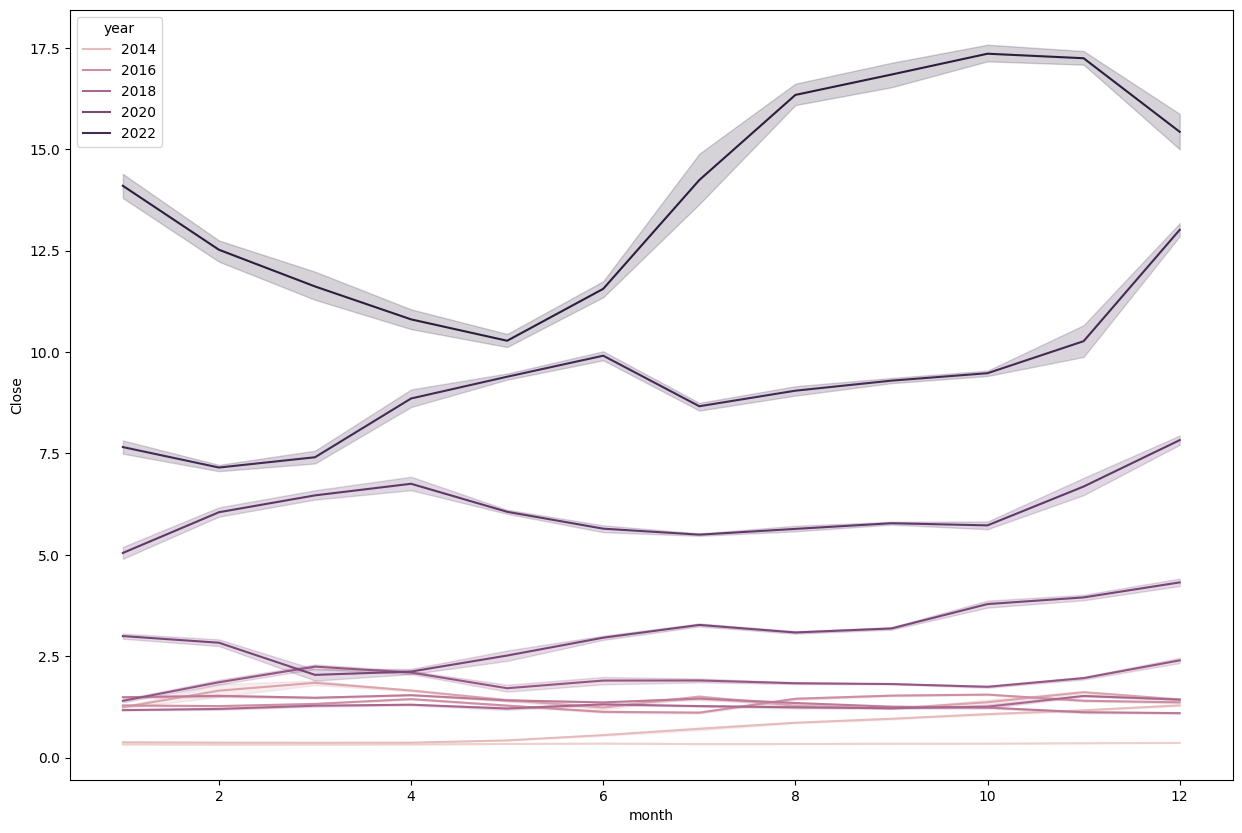

In [14]:
#geleceği tahmin etme , 365 gün sonrası
plt.figure(figsize=(15,10))
sns.lineplot(data=secilen_hisse, x='month', y='Close', hue='year')

model = Prophet()
model.fit(secilen_hisse.rename(columns={'Date': 'ds', 'Close': 'y'}))  # Sütunları yeniden adlandırın
forecastnew = model.make_future_dataframe(periods=365)
predictions = model.predict(forecastnew)
plot_plotly(model, predictions).update_layout(title="Gelecek Yıl Tahmini")

In [15]:
# hisse senedi güncel Canlı fiyatı çekme
lv_hissee = yf.Ticker("VESBE.IS")
live_price = lv_hissee.history(period="1d")["Close"].iloc[0]
print("SISE canlı fiyatı:", live_price)

SISE canlı fiyatı: 15.270000457763672
